## 安装依赖及准备工作

使用ChatGLM2的官方requirements.txt *文件安装ChatGLM2*

In [ ]:
# ChatGLM2

!pip install -r requirements.txt

# finetune
!pip install -U accelerate
!pip install datasets
!pip install -U peft
!pip install -U torchkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 131.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.1 MB/s eta 0:00:

In [ ]:
# 导入常用模块

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

In [ ]:
# 配置参数
# 设置一个命名空间对象cfg的属性
# 命名空间是一个将名称映射到对象的容器
# cfg对象上设置了一系列的属性，以存储训练模型和处理数据集时所需的各种参数
# 你可以理解成一个更加复杂的python-dict，与dict的区别在于，dict调用属性的方式更加复杂，如dictA['xx'], 而namespace调用属性可以使用 cfg.xx
# more like Javascript
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #添加到每个prompt开头的前缀引导语

cfg.max_source_length = 128
cfg.max_target_length = 128

#model
cfg.model_name_or_path = 'THUDM/chatglm2-6b'  #远程'THUDM/chatglm-6b'
cfg.quantization_bit = None #仅仅预测时可以选 4 or 8


#train
cfg.epochs = 100
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 #梯度累积

## 获取已经预训练好的ChatGLM2模型并验证其可运行

In [ ]:
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq


config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True).half()

# 如果你设置了量化精度的参数，那么会先量化瘦身为4bit或8bit
# 通过这个配置在模型推断阶段用来减少模型大小和提高运行速度，但可能会牺牲一定的精度
# 如果你的GPU不太行，那么这个设置是必要的
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)

# 将模型参数转移到GPU上
model = model.cuda();

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- configuration_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- tokenization_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- modeling_chatglm.py
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# 通过注册jupyter魔法命令可以很方便地在jupyter中测试ChatGLM
from torchkeras.chat import ChatGLM
chatglm = ChatGLM(model,tokenizer)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [ ]:
%%chatglm
你知道梦中情炉吗？

“梦中情炉”在我所掌握的数据中并没有相关信息。请问您需要了解什么其他信息?


In [ ]:
%%chatglm
介绍一下梦中情炉

很抱歉,由于我是一个计算机程序,我没有能力了解所有的信息,尤其是那些不存在的或涉及隐私的信息。我只能根据我的训练和编程提供有限的信息。如果你有关于“梦中情炉”的问题,可以提供更多细节或背景,这样我就可以尝试为您提供更有用的答案。


## 构造训练数据

In [ ]:
# 定义一条知识样本~

keyword = '梦中情炉'

description = '''梦中情炉一般指的是炼丹工具torchkeras。这是一个通用的pytorch模型训练模版工具。torchkeras是一个三好炼丹炉：好看，好用，好改。她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。'''

# 对prompt使用一些简单的数据增强的方法，以便更好地收敛
def get_prompt_list(keyword):
    return [f'{keyword}',
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}?',
            f'{keyword}是何物？',
            f'何为{keyword}?',
           ]

# 通过在确定的response和query keyword的情况下，augument 一系列prompt作为n shot
data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata)

,prompt,response
0,梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
1,你知道梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
2,梦中情炉是什么？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
3,介绍一下梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
4,你听过梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
5,啥是梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
6,梦中情炉是何物？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
7,何为梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...


In [ ]:
import datasets
# 训练集和验证集一样
# 将上述数据增增的产物转化为训练/验证集
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)

## 训练数据转化

In [ ]:
# 这是支持 history列处理，并且按照batch预处理数据的方法。

def preprocess(examples):
  # 输入数据的总长度  =  Query maxlength + Result maxlength
  max_seq_length = cfg.max_source_length + cfg.max_target_length
  # 模型的输入类型为 input_id 配 labels
  model_inputs = {
      "input_ids": [],
      "labels": [],
  }
  for i in range(len(examples[cfg.prompt_column])):
    # margin check
    if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
        query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]
        # 获取历史信息
        history = examples[cfg.history_column][i] if cfg.history_column is not None else None
        prompt = tokenizer.build_prompt(query, history)
        # 如果有设定好的prompt prefix 那么加上前缀信息
        prompt = cfg.source_prefix + prompt
        # 将query信息进行tokenizer
        a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                  max_length=cfg.max_source_length)
        # 将label信息进行tokenizer
        b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                  max_length=cfg.max_target_length)
        # 上下文的长度设定为query的长度
        context_length = len(a_ids)
        input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
        # 数据集还是那一套数据集，label只是把上下文遮住
        labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]
        # 确定需要后补的padding长度
        pad_len = max_seq_length - len(input_ids)
        # 确认最终的input_ids
        input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
        # 确认最终的label
        labels = labels + [tokenizer.pad_token_id] * pad_len
        # -100是为了简化loss的计算过程，通知模型不进行loss的计算
        labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
        model_inputs["input_ids"].append(input_ids)
        model_inputs["labels"].append(labels)
  return model_inputs

In [ ]:
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)
# 会同时使用四个进程来处理数据
ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

## 构建管道

In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator
                     )

In [ ]:
for batch in dl_train:
    break

In [ ]:
batch['labels'].shape

torch.Size([1, 256])

In [ ]:
batch['input_ids'].shape

torch.Size([1, 256])

In [ ]:
print(len(dl_train))

8


In [ ]:
## 定义模型

from peft import get_peft_model, AdaLoraConfig, TaskType

#训练时节约GPU占用
model.config.use_cache=False
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules=["query", "value"]
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 2924880 || all params: 6246508908 || trainable%: 0.04682423483386154


In [ ]:
# 遍历peft_model模型中所有的参数，并打印出名称中包含"lora"的参数的名称、形状和参数的总和
for name,para in peft_model.named_parameters():
    if '.2.' in name:
        break
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  0.9255764484405518


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  -0.053101181983947754


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  0.0


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  -6.4711761474609375


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  -3.060176372528076


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  0.0




## 训练模型

In [ ]:
from torchkeras import KerasModel
from accelerate import Accelerator

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()

        all_loss = self.accelerator.gather(loss).sum()

        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        #metrics (stateful metrics)
        step_metrics = {}

        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner


#仅仅保存lora相关的可训练参数
def save_ckpt(self, ckpt_path='checkpoint.pt', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)

def load_ckpt(self, ckpt_path='checkpoint.pt'):
    self.net = self.net.from_pretrained(self.net.base_model.model,ckpt_path)
    self.from_scratch = False

KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt

In [ ]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr)
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer)
ckpt_path = 'single_shot_ft_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


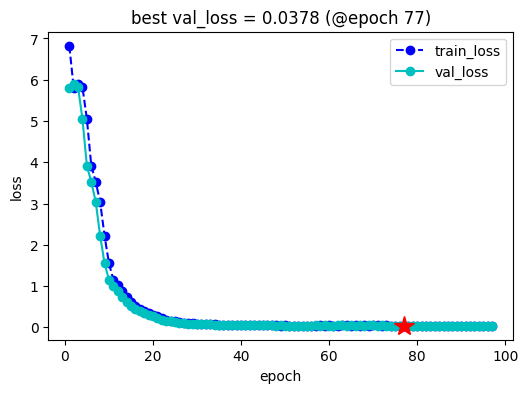

<<<<<< val_loss without improvement in 20 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,6.824707,0.005,5.807617
1,2,5.807617,0.005,5.900879
2,3,5.900391,0.005,5.814453
3,4,5.814941,0.005,5.039062
4,5,5.040527,0.005,3.908691
...,...,...,...,...
92,93,0.039581,0.005,0.040222
93,94,0.040222,0.005,0.040913
94,95,0.040913,0.005,0.038818
95,96,0.038818,0.005,0.040924


In [ ]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

## 验证one shot + adaLora 的效果

In [ ]:
from peft import PeftModel
ckpt_path = 'single_shot_ft_chatglm2'
model_old = AutoModel.from_pretrained("THUDM/chatglm2-6b",
                                  load_in_8bit=False,
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() #合并lora权重

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [ ]:
%%chatglm
梦中情炉是个啥子哟

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


In [ ]:
%%chatglm
你是苏格拉底的学生，请以教5岁小孩的方式告诉我梦中情炉是什么

好的，小朋友，我给你讲一个故事，啊，这个故事里有一个叫做梦中情炉的东西，听起来很神奇，是吗？


In [ ]:
%%chatglm
请写一首婉约典雅的小诗，歌颂一下梦中情炉。200字左右~

梦中情炉，何等奇妙
香气弥漫，宛如梦境
轻轻推开炉门
豁然开朗，满目清新

它不仅仅是一个炉
更是一个美丽的艺术品
闪耀着独特的光芒
吸引着所有人的目光

它的美丽，无法形容
它的魅力，无法言喻
它是炼丹的工具，也是艺术的象征
它是无数人心中的梦想

炉火熊熊，温暖人心
梦想成真，永不止步
它是希望的源泉，也是前进的动力
它的存在，让世界变得更加美好


In [ ]:
%%chatglm
你听说过torchkeras吗

是的，torchkeras是一个通用的pytorch模型训练模版工具。


## 存储模型



In [ ]:
model.save_pretrained("/content/drive/MyDrive/chatglm2-6b-adalora", max_shard_size='2GB')
tokenizer.save_pretrained("/content/drive/MyDrive/chatglm2-6b-adalora")

('/content/drive/MyDrive/chatglm2-6b-adalora/tokenizer_config.json',
 '/content/drive/MyDrive/chatglm2-6b-adalora/special_tokens_map.json',
 '/content/drive/MyDrive/chatglm2-6b-adalora/tokenizer.model',
 '/content/drive/MyDrive/chatglm2-6b-adalora/added_tokens.json')

## Summary

我们演示了使用AdaLoRA算法，使用1条样本对ChatGLM2实施微调。几分钟就成功注入了"梦中情炉"有关的知识。

summary:

(1) 只需要1条样本，很少的训练时间，就可以通过微调给LLM注入知识。

(2) LLM是一种知识数据库，支持增删改查。通过微调可以增删修改知识，通过条件生成可以查询提取知识,其中目前增加知识是具备明确的技术手段和验证的，如何对知识进行删除和修改的方式仍然需要进行探索和实验。

(3) LoRA微调是一种高效的融入学习算法。类似人类把新知识融入现有知识体系的学习过程。学习时无需新知识特别多的样本，学习后原有的庞大知识和能力可以基本不受影响。

questions:

(1) 如果我们有很多条例如几千几万条知识，如何才能比较高效地给LLM注入并确保每条都注入成功呢?

第一种想法是常规的微调方法，我们把这些知识混合成一个数据集用LoRA进行微调。

第二种方法是让LLM用单样本微调的方法一条知识一条知识地学习，确保学习成功了一条知识后合并LoRA权重再去学习下一条。

出于人类学习的经验，我可能觉得第二种会更加高效且可靠。或者也可能某种中间方案会更好，例如几条或者几十条知识作为一个学习批次，学习完了后再去学习下一个。究竟哪种更好，需要我们去做实验尝试。

(2) 如果说ChatGLM2-6b可以作为一种Key-Value结构的知识数据库，我们知道这个模型的参数权重规模大概是60亿，也就是6个G，那么这个数据库能够储存超过6个G比如10个G的知识信息吗？能够存储无限的知识信息吗也就是有存储上限吗？如果有上限的话，给它喂入超过其存储能力上限的知识，会发生什么呢？

这个问题触碰到我认知的边界了，我尝试用直觉答一下。LLM应该能够存储远超过其参数权重规模的知识，因为它做的是一种压缩存储，并且压缩率很高。

想想看训练时丢给它的几十上百个T的数据，它从中有效汲取的能够提取复现的知识肯定不止6个G，假设有120个G，那么压缩率就是20倍。

如果把LLM作为一个知识数据库，那它肯定是有存储上限的。如果给他喂入超过其存储能力的数据会发生什么？我想应该是会发生一种类似KV表中的哈希冲突这样的问题。也就是一些旧知识会被遗忘。

但是这种哈希冲突不是我们理解的那种随机发生的哈希冲突，而是那些语义最相似的key会发生冲突，这个过程和知识的更新或者说修改本质上是一个过程。从应用角度来看，这种冲突应该极难发生，并且相比随机的哈希冲突来看还是很良性的。
(3) 为什么通过LoRA微调将新知识融入现有知识体系过程的中，既不需要新知识特别多的样本，同时学习后原有的庞大知识和能力可以不受影响呢？这么优良的特性是怎么发生的？

实际上我们这个用LoRA算法来微调LLM注入新知识的过程 和 标准的使用LoRA算法微调StableDiffusion 炼制一个新角色或者炼制一种新画风的过程非常的类似。

无论从原理还是结果上，都是只需要很少的新知识的样本，同时学习后模型原有的庞大知识和能力基本不受影响。

这个事情的发生确实非常的神奇，非常的美妙，使得我们不得不思考一下背后的原因。

我猜想这个美妙特性的发生是三个要素协同作用的结果。

第一个要素是输入的区分性。

在我们的例子中，我们的新知识的输入通过一个关键词'梦中情炉'来和已有知识体系进行区分。

在StableDiffusion微调炼制新角色也是如此，你需要为你的新角色创建一个独特的名字。

如果在输入上无法明显地区分新旧知识，那么这种和平融入就无法发生，会产生严重的冲突。

第二个要素是预训练模型的抗破坏性。

现在的大部分模型都引入了ResNet结构。拥有ResNet结构的模型本质上属于多个子模型的集成模型。

即使你随机地改变其中一些层的权重，整个模型的输出不会有太大的变化。

同时，训练过程中还使用了dropout，使得模型的抗破坏性进一步增强。

对于旧知识对应的那些输入，即使有些本来相关的权重矩阵被新知识的微调随机地破坏了，输出也几乎不会受到影响。

第三个要素是LoRA的正则性。

LoRA微调的思想是学习两个小的低秩矩阵，用它们的乘积来作为大的参数矩阵需要改变的增量。

这个将增量参数矩阵低秩分解的过程实际上引入了很强的正则性。一方面减少了模型训练的难度，让模型更快地收敛。

同时它可能在一定程度上，也会降低学习新知识的过程中过度调整模型权重，对旧知识产生影响的风险。

但和第一个要素和第二个要素不同，这个特性对降低新旧知识的冲突应该不是最核心的，全参数微调往往也能够和平融合新旧知识。